In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Import data
Data = pd.read_csv('medical_stock_prices.csv')

# Drop date variable
Data = Data.drop(['Date'], 1)

In [2]:
data_trimmed = Data
for column in Data:
    if np.count_nonzero(~np.isnan(Data[column])) < Data.shape[0]-2:
        #print (np.count_nonzero(~np.isnan(data[column])))
        data_trimmed = data_trimmed.drop([column], 1)

In [3]:
n = data_trimmed.shape[0]
p = data_trimmed.shape[1]

# Make data a np.array
data = data_trimmed.dropna()
data = data_trimmed.values
(n, p)

(4330, 560)

In [4]:
data

array([[ 39.05827928,   4.19348132,   1.63387224, ..., 193.        ,
          4.70359518,  48.28511758],
       [ 39.69958552,   4.19348132,   1.64375147, ..., 191.19      ,
          4.55467216,  47.83490669],
       [ 40.42276065,   4.19348132,   1.63387224, ..., 190.13      ,
          4.44001462,  46.75761636],
       ...,
       [ 70.58      ,  45.62      ,  35.75      , ..., 611.12      ,
         80.57      ,  56.29      ],
       [ 69.        ,  45.95      ,  38.65      , ..., 609.84      ,
         80.18      ,  55.74      ],
       [ 68.59      ,  46.21      ,  36.75      , ..., 606.15      ,
         81.38      ,  54.97      ]])

In [5]:
data = data[~np.isnan(data).any(axis=1)]
data.shape

(4328, 560)

In [6]:
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n-50
data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]

In [7]:
data_train.shape

(3464, 560)

In [8]:
np.count_nonzero(np.isnan(data_train))

0

In [30]:
# Scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

# Build X and y
X_train = data_train[0:-5, 0:]
y_train = data_train[5:, 0]
X_test = data_test[0:-5, 0:]
y_test = data_test[5:, 0]

#y_train/ test should be A and AAN

(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


((3459, 560), (3459,), (810, 560), (810,))

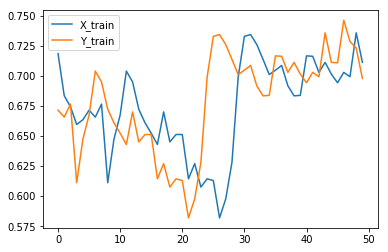

In [31]:
plt.plot(X_train[-50:, 0])
plt.plot(y_train[-50:])
plt.legend(["X_train", "Y_train"])
plt.show()

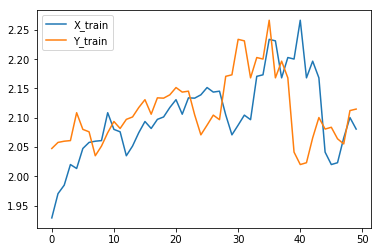

In [32]:
plt.plot(X_test[-50:, 0])
plt.plot(y_test[-50:])
plt.legend(["X_train", "Y_train"])
plt.show()

In [33]:
(X_train[-10:-5, 0], y_train[-15:-10])

(array([0.71672931, 0.71636779, 0.70299135, 0.71130643, 0.70154525]),
 array([0.71672931, 0.71636779, 0.70299135, 0.71130643, 0.70154525]))

In [34]:
# Number of stocks in training data
n_stocks = X_train.shape[1]

# Neurons
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128

# Session
net = tf.InteractiveSession()

# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Hidden weights
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Output weights
W_out = tf.Variable(weight_initializer([n_neurons_4, 1]))
bias_out = tf.Variable(bias_initializer([1]))

# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_4), bias_hidden_4))

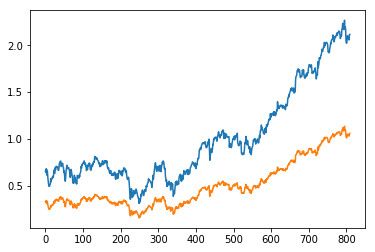

In [35]:
# Output layer (transpose!)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# Init
net.run(tf.global_variables_initializer())
# Setup plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test[:])
line2, = ax1.plot(y_test[:] * 0.5)
plt.show()


In [36]:
# Fit neural net
batch_size = 256
mse_train = []
mse_test = []

In [37]:
# Run
epochs = 15
for e in range(epochs):

    # Shuffle training data
    #shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    #X_train = X_train[shuffle_indices]
    #y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
        if np.mod(i, 50) == 0:
            # MSE train and test
            mse_train.append(net.run(mse, feed_dict={X: X_train, Y: y_train}))
            mse_test.append(net.run(mse, feed_dict={X: X_test, Y: y_test}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
            print('\n')
            # Prediction
            pred = net.run(out, feed_dict={X: X_test})
            #line2.set_ydata(pred)
            #plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
            #plt.pause(0.01)

MSE Train:  4.185033
MSE Test:  0.6125468


MSE Train:  2.0429683
MSE Test:  37.548298


MSE Train:  7.0154157
MSE Test:  185.65553


MSE Train:  2.6704938
MSE Test:  39.149803


MSE Train:  0.8099595
MSE Test:  0.1742995


MSE Train:  0.23393546
MSE Test:  2.528369


MSE Train:  0.24537532
MSE Test:  0.13200444


MSE Train:  0.19116364
MSE Test:  5.0282


MSE Train:  0.11010488
MSE Test:  1.8935643


MSE Train:  0.057521485
MSE Test:  1.7956735


MSE Train:  0.0303037
MSE Test:  0.09008321


MSE Train:  0.0335063
MSE Test:  0.08829968


MSE Train:  0.03047565
MSE Test:  0.19713329


MSE Train:  0.017929781
MSE Test:  0.08801983


MSE Train:  0.01757254
MSE Test:  0.10317655




In [38]:
data_last50 = data[np.arange(-50, -0), :]
data_last50

array([[ 67.61,  36.93,  35.2 , ..., 577.24,  82.3 ,  50.01],
       [ 67.66,  38.28,  35.95, ..., 576.23,  83.11,  50.98],
       [ 67.75,  40.71,  35.35, ..., 577.5 ,  82.86,  50.89],
       ...,
       [ 70.58,  45.62,  35.75, ..., 611.12,  80.57,  56.29],
       [ 69.  ,  45.95,  38.65, ..., 609.84,  80.18,  55.74],
       [ 68.59,  46.21,  36.75, ..., 606.15,  81.38,  54.97]])

In [39]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_last50)
data_last50 = scaler.transform(data_last50)

X_last50 = data_last50[:, 0:]
y_last50 = data_last50[:, 0]
(X_last50.shape, y_last50.shape)

((50, 560), (50,))

In [40]:
pred = net.run(out, feed_dict={X: X_last50})
pred[0].shape

(50,)

In [41]:
X_last50.shape

(50, 560)

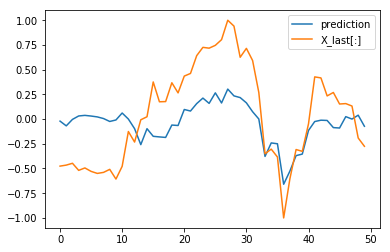

In [42]:
#plt.plot(y_last45)
plt.plot(pred[0])
#plt.plot(X_last50[:, 0])
plt.plot(X_last50[:,0])
plt.legend(["prediction", "X_last[:]"])
plt.show()

In [422]:
X_one_week_ago = data_last50[-10:-5, 0:]
X_one_week_ago.shape
X_one_week_ago

array([[ 69.7 ,  40.33,  34.35, ..., 588.09,  77.88,  54.51],
       [ 72.02,  43.79,  34.6 , ..., 589.58,  78.97,  54.75],
       [ 71.97,  43.4 ,  35.05, ..., 595.88,  78.25,  55.07],
       [ 71.08,  42.56,  34.35, ..., 589.09,  78.08,  54.97],
       [ 71.25,  43.86,  34.45, ..., 591.74,  77.81,  55.86]])

In [423]:
pred = net.run(out, feed_dict={X: X_one_week_ago})
pred[0]

array([57.11361 , 57.570305, 57.52961 , 57.068336, 56.835167],
      dtype=float32)

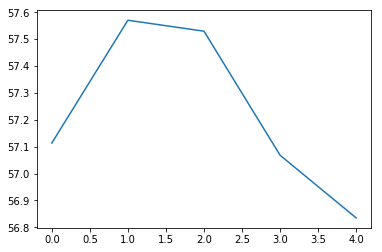

In [424]:
plt.plot(pred[0])

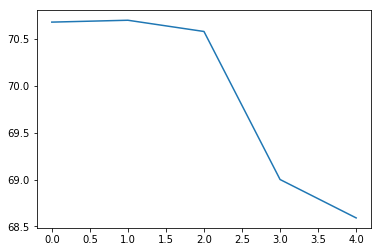

In [425]:
plt.plot(data[-5:,0])

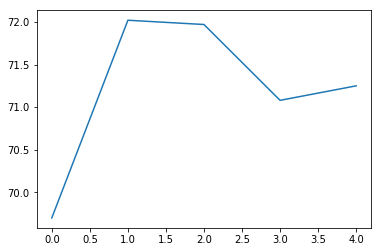

In [426]:
plt.plot(data[-10:-5,0])

### Let's try comparing stocks with their own past week

In [632]:
T = Data[['A']]
T = T.transpose()
T = np.array(T)
T.shape

(1, 4330)

In [ ]:
X_last = []
for i in range(T.shape[1] - 35, T.shape[1] - 21 ):
    X_last.append(T[0, i:i+21])
X_last = np.array(X)
X.shape

In [633]:
X = []
for i in range(1, T.shape[1] - 35):
    X.append(T[0, i:i+21])
X = np.array(X)
X.shape

(4294, 21)

In [634]:
T = np.array(np.transpose(y))
T = T[29:-7]
T.shape

(4294, 1)

In [635]:
(T[-1], X[-1])

(array([71.97]),
 array([70.05, 71.77, 70.79, 70.8 , 71.73, 71.23, 72.06, 72.19, 73.07,
        73.48, 73.44, 73.58, 73.86, 74.82, 74.53, 72.99, 73.43, 72.83,
        71.25, 68.22, 68.45]))

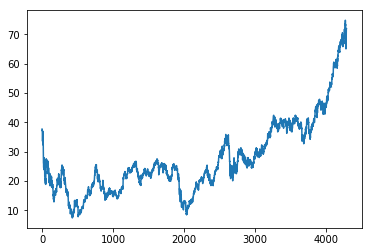

In [637]:
plt.plot(T)

In [638]:
nRows = X.shape[0]
rows = np.arange(nRows)
#np.random.shuffle(rows)
nTrain = int(nRows * 0.8)
trainRows = rows[:nTrain]
testRows = rows[nTrain:]
Xtrain, Ttrain = X[trainRows, :], T[trainRows, :]
Xtest, Ttest = X[testRows, :], T[testRows, :]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((3435, 21), (3435, 1), (859, 21), (859, 1))

In [676]:
# Number of stocks in training data
n_stocks = Xtrain.shape[1]

# Neurons
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128

# Session
net = tf.InteractiveSession()

# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
T = tf.placeholder(dtype=tf.float32, shape=[None, 1])

# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Hidden weights
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Output weights
W_out = tf.Variable(weight_initializer([n_neurons_4, 1]))
bias_out = tf.Variable(bias_initializer([1]))

# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_4), bias_hidden_4))

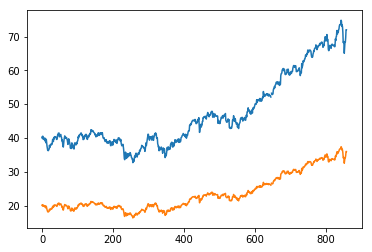

In [677]:
# Output layer (transpose!)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, T))

# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# Init
net.run(tf.global_variables_initializer())
# Setup plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(Ttest[:])
line2, = ax1.plot(Ttest[:] * 0.5)
plt.show()


In [678]:
# Fit neural net
batch_size = 20
mse_train = []
mse_test = []

In [667]:
(batch_x.shape, batch_t.shape)

((20, 21), (20, 1))

In [662]:
(X,T)

(<tf.Tensor 'Placeholder_48:0' shape=(?, 21) dtype=float32>,
 <tf.Tensor 'Placeholder_49:0' shape=(?,) dtype=float32>)

In [679]:
# Run
epochs = 15
for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(Ttrain)))
    Xtrain = Xtrain[shuffle_indices]
    Ttrain = Ttrain[shuffle_indices]

    # Minibatch training
    for i in range(0, len(Ttrain) // batch_size):
        start = i * batch_size
        batch_x = Xtrain[start:start + batch_size]
        batch_t = Ttrain[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, T: batch_t})

        # Show progress
        if np.mod(i, 50) == 0:
            # MSE train and test
            mse_train.append(net.run(mse, feed_dict={X: Xtrain, T: Ttrain}))
            mse_test.append(net.run(mse, feed_dict={X: Xtest, T: Ttest}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
            print('\n')
            # Prediction
            pred = net.run(out, feed_dict={X: Xtest})
            #line2.set_ydata(pred)
            #plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
            #plt.pause(0.01)

MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train:  nan
MSE Test:  nan


MSE Train: